In [28]:
import pandas as pd
import numpy as np

# Finance
import mplfinance as mpf
import ta

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn


# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq


In [4]:
load_dotenv()
cur_dir = Path.cwd()

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")



# Fetch Tick Data
- Add feature to pull from data instead of fetching

In [7]:
# TODO: Scale this up to n years
ticker = "NVDA"
max_limit = 50000
start_date = "2000-01-01"
end_date = "2024-12-31"

api_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit={max_limit}&apiKey={POLYGON_API_KEY}"



In [ ]:
str = "N" # Reset
str = input("Confirm?")

if str == "Y":
    resp = requests.get(api_url)
    print(f"Request made.")

In [ ]:
resp

In [ ]:
cols = ["Date", "Open", "High", "Low", "Close", "Volume", "VWAP", "Transactions"]
if resp.status_code == 200:
    dict_list = resp.json().get('results')
    df = pd.DataFrame(dict_list)

    column_map = {
        't': 'Timestamp',
        'o': 'Open',
        'h': 'High',
        'l': 'Low',
        'c': 'Close', 
        'n': 'Transactions', # Number of trades (market activity)
        'v': 'Volume', # Number of shares traded (intensity of the activity)
        'vw': 'VWAP'
    }

    df.rename(columns=column_map, inplace=True)

    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df['Date'] = df['Datetime'].dt.normalize() # Remove the time and return date object

    df = df[cols]
    df.set_index(keys="Date", inplace=True)
else:
    print(f"Error fetching data: {resp.status_code}, {resp.text}")

In [ ]:
df


In [14]:
root_dir = path_yq.get_root_dir(cur_dir=cur_dir)
csv_path = Path.joinpath(root_dir, "data", f"{ticker}_{start_date}_{end_date}.csv")

# Get df
try:
    df.to_csv(csv_path)
except NameError:
    print(f"df not defined, trying to fetch from csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)

        

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(keys="Date", inplace=True)

mpf plot: https://github.com/matplotlib/mplfinance?tab=readme-ov-file

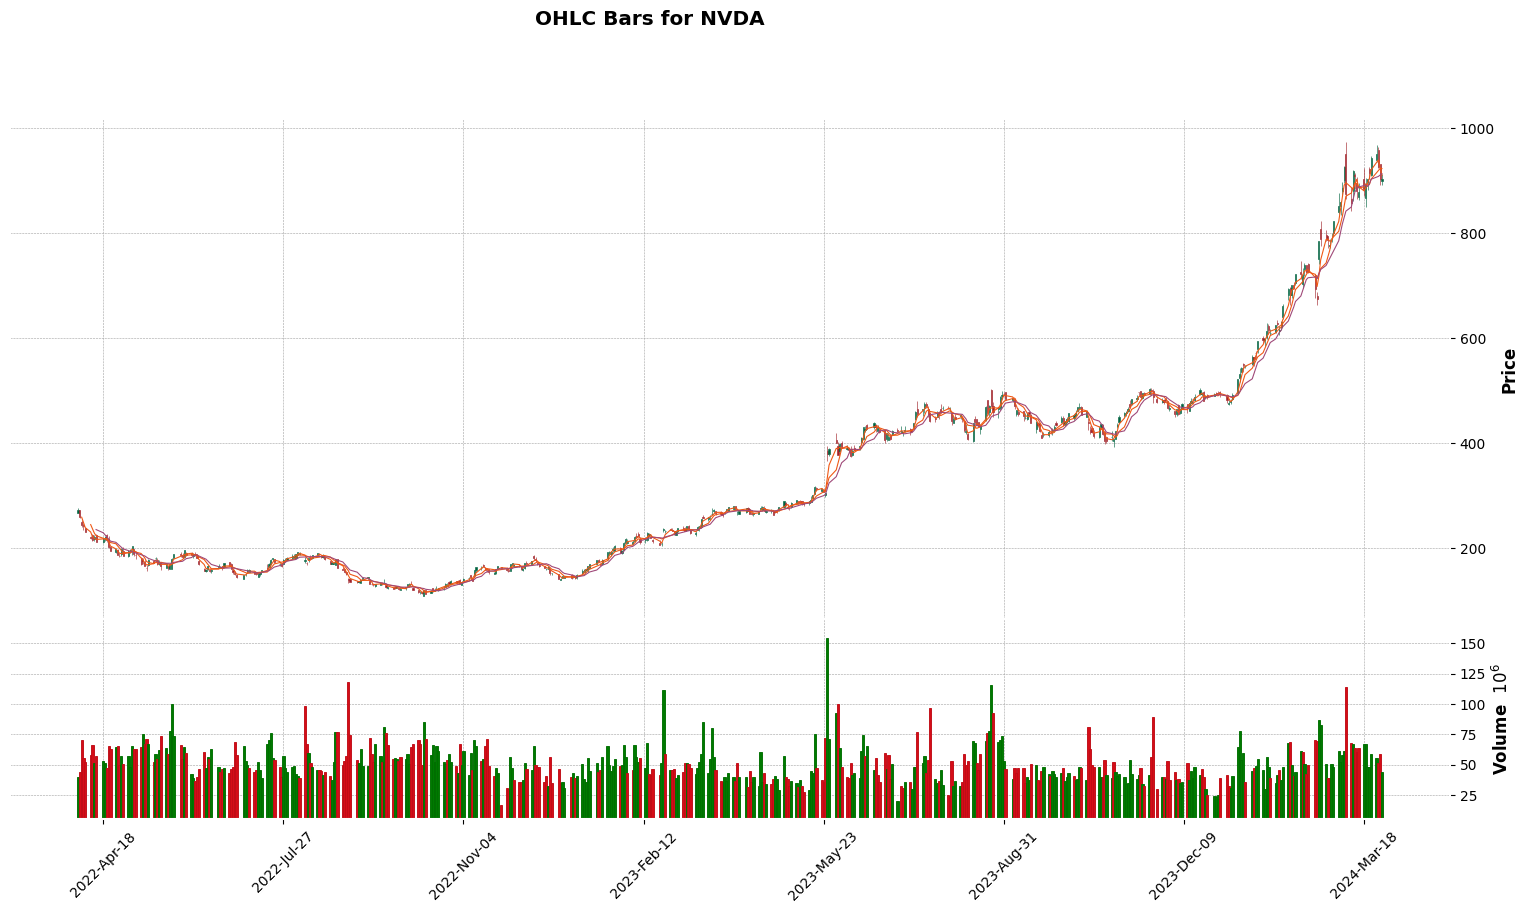

In [25]:
mpf.plot(df, type='candle', style='charles', figsize=(20, 10), title="OHLC Bars for NVDA", volume=True, show_nontrading=True, mav=(3, 6, 9))

In [27]:
df.isna().sum()


Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Transactions    0
dtype: int64

# Features
- Technical indicators
- Fundamental indicators
- Date features
- Holiday indicators etc.

# Preprocessing
- 
- Train-test split
- Scale data (only fit-transform for train, but not for test)
- Decide which to predict. Have open and predict the close for the same day? Have the close for the previous day and predict next open?



In [29]:
def create_technical_indicators(tmp: pd.DataFrame):
    df = tmp.copy(deep=True)

    # Use the close price to create the indicators
    df['BB High'], df['BB Low']= ta.volatility.bollinger_hband(df['Close']), ta.volatility.bollinger_lband(df['Close'])

    # Takes the past 20 data, including the current one to calculate the mean
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['MA_5'] = df['Close'].rolling(window=5).mean()

    df['Future Close'] = df['Close'].shift(-1)

    return df

In [35]:
df2 = create_technical_indicators(tmp=df)

In [36]:
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,
2022-04-04,267.28,275.5800,266.1300,273.60,39770782.0,272.5287,499185,NaN,NaN,NaN,NaN,NaN,259.31
2022-04-05,272.54,273.1900,258.2000,259.31,43654352.0,262.9166,639993,NaN,NaN,NaN,NaN,NaN,244.07
2022-04-06,249.34,253.0000,240.0300,244.07,70076148.0,245.2649,988183,NaN,NaN,NaN,NaN,NaN,242.08
2022-04-07,244.41,247.2200,234.7800,242.08,55799236.0,241.5490,714654,NaN,NaN,NaN,NaN,NaN,231.19
2022-04-08,239.17,239.2300,230.6201,231.19,52478064.0,233.2497,671401,NaN,NaN,NaN,NaN,250.050,219.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,911.41,947.7799,908.3401,942.89,58641936.0,935.1787,1161163,965.179031,770.070469,740.1117,867.62475,907.898,950.02
2024-03-25,939.41,967.6599,935.1000,950.02,55204733.0,954.4802,1113327,972.764014,778.395486,748.1477,875.57975,920.992,925.61
2024-03-26,958.51,963.7500,925.0200,925.61,51164758.0,944.5258,984593,972.977240,792.042260,755.7179,882.50975,927.318,902.50


In [37]:
df2.dropna(inplace=True)
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,
2022-06-14,157.310,160.6600,154.1200,158.36,46953452.0,157.6400,479628,199.181719,154.609281,193.1202,176.89550,170.306,165.27
2022-06-15,160.950,168.6800,159.2600,165.27,56393565.0,163.4682,560818,198.791225,153.349775,190.9536,176.07050,166.064,156.01
2022-06-16,158.600,159.4232,154.0100,156.01,54484867.0,155.9775,568658,199.608940,151.195060,188.8876,175.40200,161.170,158.80
2022-06-17,156.480,159.9500,153.2800,158.80,63033397.0,157.8160,496529,200.000810,149.559190,187.1822,174.78000,158.982,165.66
2022-06-21,164.745,170.0800,164.0700,165.66,48307138.0,167.5516,518114,200.022415,149.409585,185.6538,174.71600,160.820,163.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,923.000,926.4800,904.0500,914.35,47969971.0,916.4411,1005129,956.878929,762.898571,732.1239,859.88875,894.993,942.89
2024-03-22,911.410,947.7799,908.3401,942.89,58641936.0,935.1787,1161163,965.179031,770.070469,740.1117,867.62475,907.898,950.02
2024-03-25,939.410,967.6599,935.1000,950.02,55204733.0,954.4802,1113327,972.764014,778.395486,748.1477,875.57975,920.992,925.61


## Split data

In [40]:
X = 

array([[157.31   , 160.66   , 154.12   , ..., 176.8955 , 170.306  ,
        165.27   ],
       [160.95   , 168.68   , 159.26   , ..., 176.0705 , 166.064  ,
        156.01   ],
       [158.6    , 159.4232 , 154.01   , ..., 175.402  , 161.17   ,
        158.8    ],
       ...,
       [939.41   , 967.6599 , 935.1    , ..., 875.57975, 920.992  ,
        925.61   ],
       [958.51   , 963.75   , 925.02   , ..., 882.50975, 927.318  ,
        902.5    ],
       [931.12   , 932.4    , 891.23   , ..., 888.80325, 927.074  ,
        903.56   ]])